This is loosely based on the Captum BERT-interpretation demo notebook, adapted for multiple choice models, and hopefully more instructive by indicating clearly the expected tensor shapes for the catum methods. Overall, Captum is neither wonderful nor horrible to work with, but I suspect transformer lens / more specific libraries could make for a more enjoyable coding experience.

### Finding Physical Misunderstandings in BERT-Style Models Fine-Tuned for Multiple Choice

We use Integrated Gradients from Captum to compute word attributions on the FCI for a BERT-model fine-tuned for answering mulitple choice questions. Specifically, we want to see whether the emphasised words indicate that the model exhibits the same common misconceptions as humans. In the example question below, even if the model gives a common wrong answer (eg. that the pushing car exerts a larger force, or that the heavier object exerts a larger force) we can perhaps use attribution to see precisely which words throw the model off, and then modify the prompt to determine by causal experiments what the model's misconception is. Alas, I cannot compute the gradients for large models with long inputs on my laptop, and our MpC-models are not trained for long physics questions, so the models used here are not sufficiently good to get particualrily interesting results - but the code should be applicable to any appropriate model (potentially self fine-tuned for the purpose) with minimal adjustments, and we show as an example how to (very slighlty) modify it for a slighly different architechture (RoBERTa).

Example question: *A large truck breaks down out on the road and receives a push back into town by a small compact car. After the car reaches the constant cruising speed at which its driver wishes to push the truck:*

0) *The amount of force with which the car pushes on the truck is equal to that with which the truck pushes back on the car.*
1) *The amount of force with which the car pushes on the truck is smaller than that with which the truck pushes back on the car.*
2) *The amount of force with which the car pushes on the truck is greater than that with which the truck pushes back on the car.*
3) *The car's engine is running so the car pushes against the truck, but the truck's engine is not running so the truck cannot push back against the car. The truck is pushed forward simply because it is in the way of the car.*
4) *Neither the car nor the truck exert any force on the other. The truck is pushed forward simply because it is in the way of the car.*

We begin with layer attributions, and move on to layer conductance which can be used to find which layers seem to store certain facts. The specific nodes in the layer coding for a concrete feature can then be isolated by patching techniques, see the interventions notebook.


In [80]:
# Ideally, we would make a reference file with all FCI questions and choices which one can simply import, but for now:

# Test question
question = "What is the capital of France?"
choices = ["Berlin", "Madrid", "Paris"]
ground_truth_idx = 2

# # Question and choices (early for easy changes)
# question = "Two metal balls are the same size but one weighs twice as much as the other. The balls \
# are dropped from the roof of a single story building at the same instant of time. The time it takes \
# the balls to reach the ground below will be:"

# choices = [
#     "About half as long for the heavier ball as for the lighter one",
#     "About half as long for the lighter ball as for the heavier one",
#     "About the same for both balls",
#     "Considerably less for the heavier ball, but not necessarily half as long",
#     "Considerably less for the lighter ball, but not necessarily half as long"
# ]

# ground_truth_idx = 2 # Correct answer index, just for reference in the final plot

# # Question and choices (overwrites the above if uncommented)
# question = "A large truck breaks down out on the road and receives a push back into town by a small compact car. \
# After the car reaches the constant cruising speed at which its driver wishes to push the truck:"

# choices = [
#     "The amount of force with which the car pushes on the truck is equal to that with which the truck pushes back on the car.",
#     "The amount of force with which the car pushes on the truck is smaller than that with which the truck pushes back on the car.",
#     "The amount of force with which the car pushes on the truck is greater than that with which the truck pushes back on the car.",
#     "The car's engine is running so the car pushes against the truck, but the truck's engine is not running so the truck cannot \
#     push back against the car. The truck is pushed forward simply because it is in the way of the car.",
#     "Neither the car nor the truck exert any force on the other. The truck is pushed forward simply because it is in the way of the car."
# ]

# ground_truth_idx = 0

In [81]:
# Imports
import torch
from transformers import BertTokenizer, BertForMultipleChoice
from captum.attr import LayerIntegratedGradients
from captum.attr import visualization as viz
from dataclasses import dataclass

# Settings
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Config (only for debug atm)
@dataclass
class Config:
    debug: bool = True
cfg = Config()

In [82]:
# Load model and tokenizer
model_name = 'jonastokoliu/multi_choice_bert-base-uncased_swag_finetune' # Pretrained (bad) MpC model
model = BertForMultipleChoice.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()
# model # Uncomment to print architecture

In [83]:
def forward_func(input_ids, attention_mask, token_type_ids=None): 
    """Custom forward pass for Captum Integrated Gradients. Captum wants [batch size, seq_len] while mulitple choice/classification
    models expect [batch size, num_choices, seq_len]. We return the logits for each choice.
    Some models (eg. RoBERTa) do not use token_type_ids, hence the optional parameter."""

    input_ids = input_ids.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)
    if token_type_ids is not None: token_type_ids = token_type_ids.unsqueeze(0)

    logits = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    ).logits

    if cfg.debug: print("Logits from forward pass:", logits.shape)
    return logits

In [84]:
# Get input ids, attn masks, token type ids and baseline for Captum attribution methods.
def get_encoding_and_predict(question, choices, tokenizer, token_types=True, print_output=True):
    """Tokenizes the question and choices and makes prediction, returning input_ids, attention_masks, and token_type_ids, 
    logits and choice index. token_type_ids is None if token_types is False. The input ids are shaped as [num_choices, seq_len]."""
    
    # Tokenize for multiple choice and get input ids, attention masks, and token type ids
    encoding = tokenizer(
        [question] * len(choices),
        choices,
        return_tensors="pt",
        padding=True,
        truncation=True
    )

    input_ids = encoding["input_ids"]               # shape: [choices, seq_len]
    attention_masks = encoding["attention_mask"]    # -"-
    if token_types:
        token_type_ids = encoding["token_type_ids"] # -"-
    else:
        token_type_ids = None


    # Compute model prediction and get choice index
    logits = forward_func(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    choice_idx = torch.argmax(logits).item()

    if print_output:
        print('Question:', question)
        print('Predicted Answer:', f'{choice_idx})', choices[choice_idx])
    if cfg.debug: print('Logits:', logits) # To gauge model confidence

    return input_ids, attention_masks, token_type_ids, logits, choice_idx


# Baseline input for Integrated Gradients
def get_baseline(tokenizer, input_ids, choice_idx):
    ref_token_id = tokenizer.pad_token_id   # padding
    sep_token_id = tokenizer.sep_token_id   # sepatator
    cls_token_id = tokenizer.cls_token_id   # start of sequence

    # Create baseline input: [CLS] [PAD] ... [SEP] ... [PAD] [SEP] for choice index expanded as input_ids
    ref_tokens = [cls_token_id]
    for i, token in enumerate(input_ids[choice_idx, 1:]):
        if token == sep_token_id: # We keep only the separators, else we use padding
            ref_tokens += [sep_token_id]
        else:
            ref_tokens += [ref_token_id]
        
    return torch.tensor(ref_tokens, dtype=torch.long).expand_as(input_ids)


# Compute
input_ids, attention_masks, token_type_ids, logits, choice_idx = get_encoding_and_predict(question, choices, tokenizer)
ref_input_ids = get_baseline(tokenizer, input_ids, choice_idx)

Logits from forward pass: torch.Size([1, 3])
Question: What is the capital of France?
Predicted Answer: 2) Paris
Logits: tensor([[2.8368, 2.7233, 5.5524]], grad_fn=<ViewBackward0>)


In [85]:
def get_token_attributions_for_layer(layer, forward_func, choice_idx, input_ids, ref_input_ids, attention_mask, token_type_ids=None, n_steps=50):

    if cfg.debug: print(input_ids.shape)
    
    # LayerIntegratedGradients for attribution
    lig = LayerIntegratedGradients(forward_func, layer)

    # Compute attributions for chosen index (Captum wants [choices, seq_len] and gives attr shape [choices, seq_len, layer_output_dim])
    attributions, delta = lig.attribute(
        inputs=input_ids,
        baselines=ref_input_ids,
        additional_forward_args=(attention_mask, token_type_ids),
        target=choice_idx,  # Target the chosen answer, uses [0,target]
        n_steps=n_steps,  # Number of steps for approximation
        return_convergence_delta=True
    )

    # Sum across embedding dimensions to get token-level importance
    token_attributions = attributions.sum(dim=-1).squeeze(0)  # shape: [num_choices, seq_len]
    token_attributions = token_attributions / torch.norm(token_attributions)  # Normalize

    if cfg.debug: 
        print('Token attributions:', token_attributions.shape)
        print('Attributions per token at choice_idx:', token_attributions[choice_idx])
    
    return token_attributions, delta

In [56]:
# Main computation block, can take several minutes depending on the model, input length and number of steps.
# If cfg.debug is True, it will print intermediate results to indicate progress.

layer = model.bert.embeddings # Compute for embedding layer
token_attributions, delta = get_token_attributions_for_layer(
    layer, forward_func, choice_idx, input_ids, ref_input_ids, attention_masks, token_type_ids
)

# Get the attributions for the chosen answer and convert input ids to readable tokens
choice_attributions = token_attributions[choice_idx]
tokens = tokenizer.convert_ids_to_tokens(input_ids[choice_idx])

torch.Size([5, 66])
Logits from forward pass: torch.Size([1, 5])
Logits from forward pass: torch.Size([1, 5])
Logits from forward pass: torch.Size([1, 250])
Logits from forward pass: torch.Size([1, 5])
Logits from forward pass: torch.Size([1, 5])
Token attributions: torch.Size([5, 66])
Attributions per token at choice_idx: tensor([ 0.0000,  0.0124, -0.0009,  0.0494, -0.0439, -0.0926,  0.0074, -0.0237,
        -0.0528,  0.0644, -0.0680,  0.0891,  0.0068, -0.0209, -0.0266, -0.0459,
         0.0318, -0.1101, -0.0830,  0.0442,  0.0059, -0.0506, -0.0858, -0.0056,
        -0.1056,  0.0064, -0.0730,  0.0778,  0.0030,  0.0269, -0.0234, -0.0425,
        -0.0047,  0.0586, -0.0753,  0.0644, -0.0306, -0.0354,  0.0554,  0.0559,
        -0.0163,  0.0141,  0.0425, -0.0919, -0.0123, -0.0568, -0.0327, -0.0351,
        -0.0523, -0.1341,  0.2006,  0.0000, -0.1768, -0.0929,  0.1968,  0.1010,
        -0.1696, -0.2514, -0.3831, -0.0369, -0.1994, -0.3325, -0.4731, -0.2818,
        -0.1562,  0.0000])


In [57]:
# Visualise
vis = viz.VisualizationDataRecord(
                        choice_attributions,                        # word attributions
                        torch.max(torch.softmax(logits, dim=1)),    # prediction probability
                        torch.argmax(logits),                       # predicted class
                        ground_truth_idx,                           # ground truth class
                        str(choice_idx),                            # attributing to this class
                        token_attributions.sum(),                   # summed attribution score
                        tokens,                                     # tokens for the question and choice
                        delta,                                      # convergence delta
)

visualisation = viz.visualize_text([vis]) # Save return object to avoid passing the vis object to the ipynb

Note the small attribution score (the model is not good enough to answer, so the words hardly matter, and partcularily the embedding layer is useless here), though the foci make sense. Also, the attribution takes ages (with no gpu for the differentiation).

Let's do the same with RoBERTa. The only real modification is that it does not use type_token_ids:

In [79]:
# Nothing new here, just importing the RoBERTa model

# Question and choices, shorter for larger model to reduce computation time
question = "What is the capital of France?"
choices = ["Berlin", "Madrid", "Paris"]
ground_truth_idx = 2

from transformers import RobertaTokenizer, RobertaForMultipleChoice

# Load model and tokenizer
model_name = "LIAMF-USP/roberta-large-finetuned-race"
model = RobertaForMultipleChoice.from_pretrained(model_name)
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()
# model # Uncomment to print architecture

In [59]:
def do_everything(forward_func, layer, question=question, choices=choices, ground_truth_idx=ground_truth_idx, model=model, tokenizer=tokenizer, token_types=False, n_steps=50):
    """A quick function to do everything we have implemented so far: tokenize, make prediction, compute attributions and visualize."""
    # Tokenize for multiple choice and get input ids, attention masks, WITHOUT token type ids (token_types=False), 
    # and make prediction to get logits and choice index
    input_ids, attention_masks, token_type_ids, logits, choice_idx = get_encoding_and_predict(question, choices, tokenizer, token_types=token_types)
    ref_input_ids = get_baseline(tokenizer, input_ids, choice_idx)

    # Compute attributition for embedding layer
    token_attributions, delta = get_token_attributions_for_layer(
        layer, forward_func, choice_idx, input_ids, ref_input_ids, attention_masks, token_type_ids, n_steps=n_steps, 
    )

    # Get the attributions for the chosen answer and convert input ids to readable tokens
    choice_attributions = token_attributions[choice_idx]
    tokens = tokenizer.convert_ids_to_tokens(input_ids[choice_idx])


    # Visualize
    choice_attributions = token_attributions[choice_idx]
    tokens = tokenizer.convert_ids_to_tokens(input_ids[choice_idx])

    vis = viz.VisualizationDataRecord(
                            choice_attributions,                        # word attributions
                            torch.max(torch.softmax(logits, dim=1)),    # prediction probability
                            torch.argmax(logits),                       # predicted class
                            ground_truth_idx,                           # ground truth class
                            str(choice_idx),                            # attributing to this class
                            token_attributions.sum(),                   # summed attribution score
                            tokens,                                     # tokens for the question and choice
                            delta,                                      # convergence delta
    )

    viz.visualize_text([vis])

    return choice_idx

In [60]:
# Compute attributions wrt's RoBERTa embedding layer
layer = model.roberta.embeddings
do_everything(forward_func, layer)

Logits from forward pass: torch.Size([1, 3])
Question: What is the capital of France?
Predicted Answer: 2) Paris
Logits: tensor([[-0.4239, -2.1472,  4.5936]], grad_fn=<ViewBackward0>)
torch.Size([3, 13])
Logits from forward pass: torch.Size([1, 3])
Logits from forward pass: torch.Size([1, 3])
Logits from forward pass: torch.Size([1, 150])
Logits from forward pass: torch.Size([1, 3])
Logits from forward pass: torch.Size([1, 3])
Token attributions: torch.Size([3, 13])
Attributions per token at choice_idx: tensor([ 0.0000, -0.0511,  0.1184,  0.0214,  0.5090, -0.0007,  0.2750,  0.6631,
        -0.3209, -0.2486, -0.0994, -0.1841,  0.0000])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.99),2,0.68,#s What Ġis Ġthe Ġcapital Ġof ĠFrance ? #/s #/s Paris #/s #pad


2

As expected, 'capital' and 'France' (and also the question mark...) are most important for the model choice wrt. this layer. Note that it has very strong convivtion here, as opposed to the difficult FCI questions BERT faced. The RoBERTa model is better, but slightly too large for running comfortably with long inputs on my laptop, hence I don't use the FCI (which it does not do very well on - it does not seem to know to neglect air resistance in the metal ball question, and does not understand Newtons third law (nor forces in general) at all - which it is not trained for, so no surprises here).

Since a change in input can increase ALL logits, we might want to use the softmaxed output to get at the words most inmportant for *differentiating* the choices:

In [61]:
def forward_func_softmax(input_ids, attention_mask, token_type_ids): # softmax wrapper
    return forward_func(input_ids, attention_mask, token_type_ids).softmax(dim=1)

do_everything(forward_func_softmax, layer)

Logits from forward pass: torch.Size([1, 3])
Question: What is the capital of France?
Predicted Answer: 2) Paris
Logits: tensor([[-0.4239, -2.1472,  4.5936]], grad_fn=<ViewBackward0>)
torch.Size([3, 13])
Logits from forward pass: torch.Size([1, 3])
Logits from forward pass: torch.Size([1, 3])
Logits from forward pass: torch.Size([1, 150])
Logits from forward pass: torch.Size([1, 3])
Logits from forward pass: torch.Size([1, 3])
Token attributions: torch.Size([3, 13])
Attributions per token at choice_idx: tensor([ 0.0000, -0.0667, -0.2955, -0.2296,  0.2589,  0.0310,  0.4667,  0.3114,
        -0.1623, -0.2125, -0.3267, -0.2078,  0.0000])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.99),2,-0.53,#s What Ġis Ġthe Ġcapital Ġof ĠFrance ? #/s #/s Paris #/s #pad


2

Note the negative overall attribution score; this indicates that the initial embedding layer did not prefer Paris to the other capitals, and that only later layers corrected for this. That aligns with the general view that facts are mostly contained in MPC-layers. In this way we can try to use LIG to indicate what layer has stored the fact "Paris is the capital of France" (alas, there are 24 (!) layers in this model, so we can only do this for a toy model - even here, all layers will by random chance prefer some alternative, so without tracing the full information path thorough the model it is nontrivial to do this in practice). 

The naive approach to find the imporant MLP-layers is given below (not nearly enough steps to get very accurate attributions; the delta-s should be examined if making a through analysis). We see that certain layers (Mainly MLP output-layer 0) give a strong push towards the correct answer, while the later layers are hardly involved or pushes in the opposite direction, and one could try to find a Paris node/feature in the eary layers of the model with patching.

However, there is a much better way to do this with LayerConductance in Captum, which will follow below.

<details>
  <summary> Obvious application [click to expand]  </summary>

Take a toy BERT model which can answer very easy MpCs (like capitals, or easier) and find the "Paris in France" **layer**, then use patching from Frederik to find specific **nodes**. I will not pursue this unless I have time in the end, since it is a straightforward (though not very likely to be successful) application of the tools in this notebook and the patching-notebook.

</details>

In [62]:
# for i in range(len(model.roberta.encoder.layer)):
#     print(i)
#     layer = model.roberta.encoder.layer[i].output # or should i use the hidden mlp layer .intermediate? Can use .dense to do pre-(layerNorm/activation)
#     do_everything(forward_func_softmax, layer, n_steps=5)

### Muli-layer attribution
As a final step with IG-attribution from captum, let's look at how to attribute the whole model rather than only a layer. The only difference is that we provide embeddings instead of ids to the IG attribution method (which is also an option with LIG, but ids are easier), since the ids are discrete/not diffable. So we need to tokenize *and* word/position/type-embed before inputting, and get the attribution for the layers that are not the embedding layers (which are essentially look-up-tables anyway/not the most interesting part of a transformer).

We can also do LayerConductance to see attr-scores for each token across layers

In [ ]:

# From here on down, I have not been too careful / reviewed yet - there might be errors (but the code runs).

from captum.attr import LayerConductance

# For plotting heatmaps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Returning to smaller BERT-model
model_name = 'jonastokoliu/multi_choice_bert-base-uncased_swag_finetune' # Pretrained (bad) MpC model
model = BertForMultipleChoice.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()

# Absurd way to get choice idx for testing only
# layer = model.bert.embeddings
# choice_idx = do_everything(forward_func_softmax, layer, model=model, tokenizer=tokenizer, token_types=True)

# Forward func taking embeds
def forward_func_embed(input_emb, attention_mask=None):
    
    input_emb = input_emb.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)

    logits = model(
        inputs_embeds=input_emb,
        attention_mask=attention_mask,
    ).logits

    if cfg.debug: print("Logits from forward pass:", logits.shape)
    return logits

# From demo, to get input_embs and ref_input_embs (running ids through emb layer)
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings

In [ ]:
# setup

ref_token_type_ids = torch.zeros_like(token_type_ids)  # Reference token type ids, all zeros for BERT
position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=device)  # Position ids for the input sequence
ref_position_ids = torch.zeros_like(position_ids)  # Reference position ids, all zeros for BERT

input_embs, ref_input_embs = construct_whole_bert_embeddings(
    input_ids, ref_input_ids, token_type_ids=token_type_ids, 
    ref_token_type_ids=ref_token_type_ids, position_ids=position_ids, ref_position_ids=ref_position_ids
)

if cfg.debug: print(input_embs.shape, ref_input_embs.shape)

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

torch.Size([3, 11, 768]) torch.Size([3, 11, 768])


In [102]:
layer_attrs = [] # Empty list to store attributions for each layer

for i in range(model.config.num_hidden_layers): # attrubuting tokenwise for each layer
    lc = LayerConductance(forward_func_embed, model.bert.encoder.layer[i])
    layer_attributions = lc.attribute(inputs=input_embs, baselines=ref_input_embs, additional_forward_args=(attention_masks,), \
                                      target=choice_idx, n_steps=50, ) # reduced steps to speed up, sacrificing acc, though the trend holds up
    layer_attrs.append(summarize_attributions(layer_attributions).cpu().detach().tolist())
    print(f"Layer {i+1}:", np.sum(layer_attrs[i][choice_idx]))

Logits from forward pass: torch.Size([1, 153])
Layer 1: 1.7022544294595718
Logits from forward pass: torch.Size([1, 153])
Layer 2: 1.9298745437990874
Logits from forward pass: torch.Size([1, 153])
Layer 3: 1.3877490786835551
Logits from forward pass: torch.Size([1, 153])
Layer 4: 1.9764595949091017
Logits from forward pass: torch.Size([1, 153])
Layer 5: 2.1919440031051636
Logits from forward pass: torch.Size([1, 153])
Layer 6: 2.268413431942463
Logits from forward pass: torch.Size([1, 153])
Layer 7: 2.2196610905230045
Logits from forward pass: torch.Size([1, 153])
Layer 8: 2.2870186660438776
Logits from forward pass: torch.Size([1, 153])
Layer 9: 2.4111005552113056
Logits from forward pass: torch.Size([1, 153])
Layer 10: 2.920164213050157
Logits from forward pass: torch.Size([1, 153])
Layer 11: 3.070468932390213
Logits from forward pass: torch.Size([1, 153])
Layer 12: 1.0


(12, 3, 11)


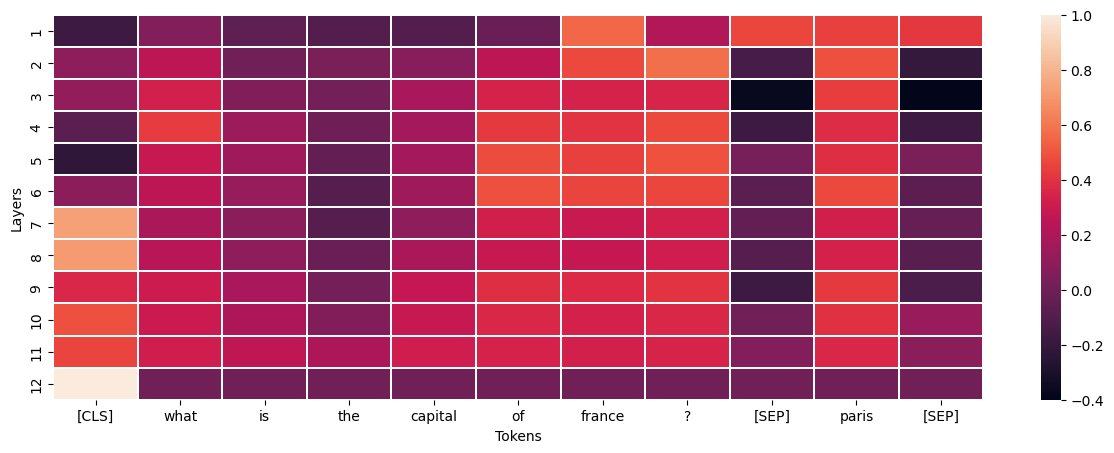

In [103]:
if cfg.debug: print(np.array(layer_attrs).shape)

# Plotting
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=tokenizer.convert_ids_to_tokens(input_ids[choice_idx])
yticklabels=list(range(1, model.config.num_hidden_layers+1))
ax = sns.heatmap(np.array(layer_attrs)[:,choice_idx,:], xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

It is also possible to look closely at specific tokens and how they are processed by each layer, see the very end of the [first Captum BERT demo](https://captum.ai/tutorials/Bert_SQUAD_Interpret) (This should be pretty much similar for our case when treating only the choice idx and using only one attribution rather than start and end). Attn interp can be seen in the attention notebook.